## Develop and test pyTMD harmonic fits with nodal corrections

1. Generate a prediction from FES + pyTMD (2015 and 2025)
2. Fit first year only (using pyTMD)
3. Predict both for all years w + w/o nodal corrections and compare results

This notebook is not intended for users of iwatlas. It requires the FES2022 model output to run. 

In [2]:
import os
import glob
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import nwatides as nwt
import timescale

fes_model = 'FES2022'
fes_dir = '/mnt/c/Users/00099894/Large_Data/Other/' + fes_model

In [3]:
import pyTMD
print(pyTMD.__version__)

2.2.7


In [20]:
seasonal_freq_list = ['M2','S2','K1','O1']
freq_list = ['N2','Q1', 'P1']

constituents = seasonal_freq_list + freq_list
constituents_lower= [c.lower() for c in constituents]

lat, lon = -20.76128333, 114.7586167  # NWSBAR

In [12]:
# default_fes_constituents = nwt.default_constituents

# constits_tmd = pyTMD.arguments.frequency(default_fes_constituents)

In [11]:
# # This is for matching iwatlas constits - ignore
# constis_float = np.array([1.405189e-04, 1.454441e-04, 1.378797e-04, 7.292116e-05, 6.759774e-05])

# # Find where tmd constits equal float constits
# matching_indices = [np.where(np.isclose(constits_tmd, cf, atol=1e-6))[0][0] for cf in constis_float]

# print('Fitting constits:')
# print([default_fes_constituents[i] for i in matching_indices])

# ssh_constits_str = [default_fes_constituents[i] for i in matching_indices]

# # Repeat each entry n times
# n = 7
# ssh_constits_str_full = [item for item in ssh_constits_str for _ in range(n)]

## Plot the nodal correction cycle


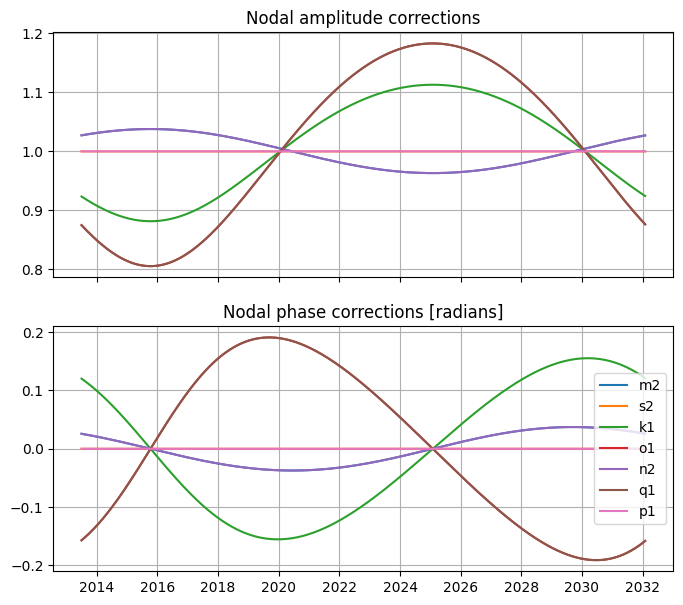

In [14]:
delta_time = np.arange(365*18.6)*timescale.time._to_sec['day']
ts = timescale.from_deltatime(delta_time, epoch=(2013,7,1,0,0,0))

pu, pf, G = pyTMD.arguments.arguments(ts.MJD, constituents=constituents_lower, corrections="FES")

fig, ax = plt.subplots(2,1, figsize=(8,7), sharex=True)
[ax[0].plot(ts.to_datetime(), pf[:,i], label=constituents_lower[i]) for i in range(len(constituents_lower))]

[ax[1].plot(ts.to_datetime(), pu[:,i], label=constituents_lower[i]) for i in range(len(constituents_lower))]

ax[0].set_title('Nodal amplitude corrections')
ax[1].set_title('Nodal phase corrections [radians]')
ax[1].legend()
for x in ax:
    x.grid()

In [15]:
# x = np.array([3000,4000])
# t = x.astype('timedelta64[s]') + np.datetime64('1990-01-01 00:00:00')

In [16]:
# Unzip the FES2022 XZ files
import lzma

def extract_xz_file(xz_filepath, output_filepath):
    """
    Decompresses a single .xz file.

    Args:
        xz_filepath (str): The path to the .xz file.
        output_filepath (str): The path where the decompressed content will be saved.
    """
    try:
        with lzma.open(xz_filepath, 'rb') as f_in:
            with open(output_filepath, 'wb') as f_out:
                f_out.write(f_in.read())
        print(f"Successfully extracted '{xz_filepath}' to '{output_filepath}'")
    except lzma.LZMAError as e:
        print(f"Error extracting XZ file: {e}")
    except FileNotFoundError:
        print(f"Error: File not found at '{xz_filepath}'")

xz_files = glob.glob(os.path.join(fes_dir, 'fes2022b', 'ocean_tide_20241025', '*.xz'))
matched_files = [f for f in xz_files if any(c.lower()+'_' in os.path.basename(f)[:3] for c in constituents)]
matched_files

['/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/k1_fes2022.nc.xz',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/m2_fes2022.nc.xz',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/n2_fes2022.nc.xz',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/o1_fes2022.nc.xz',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/p1_fes2022.nc.xz',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/q1_fes2022.nc.xz',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/s2_fes2022.nc.xz']

##### File extraction only required for zipped FES files once

In [ ]:
# # Extract the files we need
# [extract_xz_file(file, file[:-3]) for file in matched_files]

Successfully extracted '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/k1_fes2022.nc.xz' to '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/k1_fes2022.nc'
Successfully extracted '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/m2_fes2022.nc.xz' to '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/m2_fes2022.nc'
Successfully extracted '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/n2_fes2022.nc.xz' to '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/n2_fes2022.nc'
Successfully extracted '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/o1_fes2022.nc.xz' to '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/o1_fes2022.nc'
Successfully extracted '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/p1_fes2022.nc.xz' to '/mnt/c/Users/00099894/Larg

[None, None, None, None, None, None, None]

In [21]:
model_files = glob.glob(os.path.join(fes_dir, 'fes2022b', 'ocean_tide_20241025', '*.nc'))
matched_files = [f for f in model_files if any(c+'_' in os.path.basename(f)[:3] for c in constituents_lower)]
matched_files

['/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/k1_fes2022.nc',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/m2_fes2022.nc',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/n2_fes2022.nc',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/o1_fes2022.nc',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/p1_fes2022.nc',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/q1_fes2022.nc',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/s2_fes2022.nc']

## Extract the constituent values for the coordinates

In [22]:
# Get the constituent amp and phase 
amp, ph = pyTMD.io.FES.extract_constants(
    np.atleast_1d(lon), 
    np.atleast_1d(lat),
    matched_files,
    type="z",
    version=fes_model,
    method="bilinear",
    scale=1/100)

In [98]:
# Create the test and train data
delta_time = np.arange(365*24)*timescale.time._to_sec['hour']
ts = timescale.from_deltatime(delta_time, epoch=(2013,7,1,0,0,0))
DELTAT = ts.tt_ut1
ts.to_datetime()[0:3]

array(['2013-07-01T00:00:00.000000000', '2013-07-01T01:00:00.000000000',
       '2013-07-01T02:00:00.000000000'], dtype='datetime64[ns]')

In [99]:
# calculate complex phase in radians for Euler's
cph = -1j*ph*np.pi/180.0
# calculate constituent oscillation
hc = amp*np.exp(cph)

In [100]:
# predict tidal elevations at time and infer minor corrections
TIDE = pyTMD.predict.time_series(ts.MJD, hc, constituents_lower,
                                corrections='FES')
MINOR = pyTMD.predict.infer_minor(ts.MJD, hc, constituents_lower,
                                deltat=DELTAT, corrections='FES')
TIDE.data[:] += MINOR.data[:]

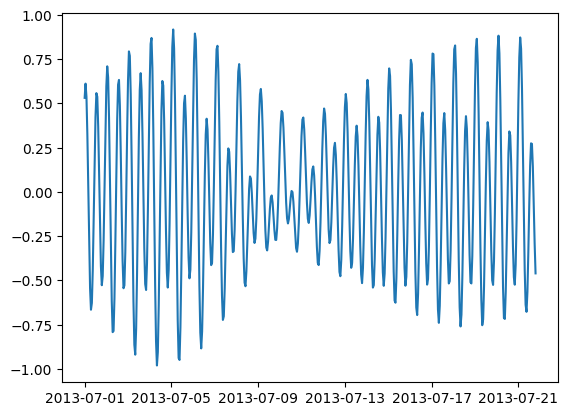

In [101]:
px = 500

plt.plot(ts.to_datetime()[:px], TIDE.data[:px], label='FES2022')

# Fit using pyTMD

In [114]:
amp_tmd, ph_tmd = pyTMD.solve.constants(ts.MJD, TIDE.data, constituents=constituents_lower,
                                        corrections="FES")

cph_tmd = -1j*ph_tmd*np.pi/180.0
# calculate constituent oscillation
hc_tmd = amp_tmd*np.exp(cph_tmd)

In [115]:
TIDE_tmd = pyTMD.predict.time_series(ts.MJD, hc_tmd, constituents_lower,
                                corrections='FES')
MINOR_tmd = pyTMD.predict.infer_minor(ts.MJD, hc_tmd, constituents_lower,
                                deltat=DELTAT, corrections='FES')
TIDE_tmd.data[:] += MINOR_tmd.data[:]

In [116]:
TIDE_no = pyTMD.predict.time_series(ts.MJD, hc_tmd, constituents_lower,
                                corrections=None)
MINOR_no = pyTMD.predict.infer_minor(ts.MJD, hc_tmd, constituents_lower,
                                deltat=DELTAT, corrections=None)
TIDE_no.data[:] += MINOR_no.data[:]

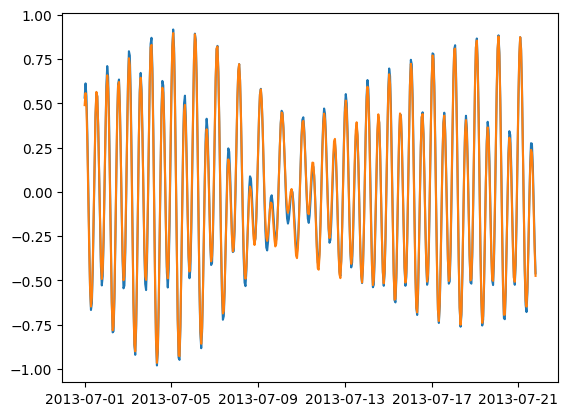

In [221]:
px = 500
# plt.plot(ts.to_datetime()[:px], TIDE.data[:px], label='FES2022')
plt.plot(ts.to_datetime()[:px], TIDE_tmd.data[:px], label='TMD (FES)')
plt.plot(ts.to_datetime()[:px], TIDE_no.data[:px], label='TMD (No Corrections)')

## Predict in the future 

In [118]:
ts_test = timescale.from_deltatime(delta_time, epoch=(2020,7,1,0,0,0))
DELTAT_test = ts_test.tt_ut1
ts_test.to_datetime()[0:3]

array(['2020-07-01T00:00:00.000000000', '2020-07-01T01:00:00.000000000',
       '2020-07-01T02:00:00.000000000'], dtype='datetime64[ns]')

In [119]:
# predict tidal elevations at time and infer minor corrections
TIDE_test = pyTMD.predict.time_series(ts_test.MJD, hc_tmd, constituents_lower,
                                corrections='FES')
MINOR_test = pyTMD.predict.infer_minor(ts_test.MJD, hc_tmd, constituents_lower,
                                deltat=DELTAT_test, corrections='FES')
TIDE_test.data[:] += MINOR_test.data[:]

In [120]:
TIDE_tmd_test = pyTMD.predict.time_series(ts_test.MJD, hc_tmd, constituents_lower,
                                corrections=None)
MINOR_tmd_test = pyTMD.predict.infer_minor(ts_test.MJD, hc_tmd, constituents_lower,
                                deltat=DELTAT_test, corrections=None)
TIDE_tmd_test.data[:] += MINOR_tmd_test.data[:]

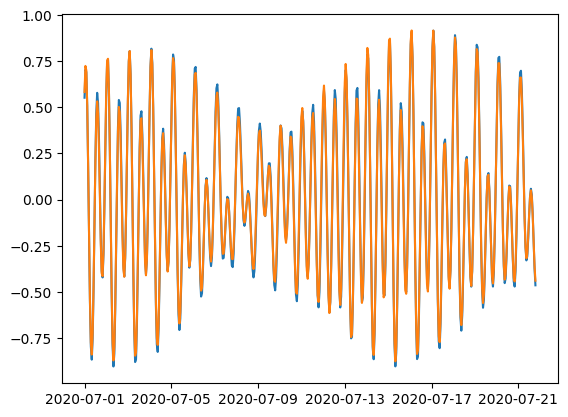

In [222]:
plt.plot(ts_test.to_datetime()[:px], TIDE_test.data[:px], label='FES2022')
plt.plot(ts_test.to_datetime()[:px], TIDE_tmd_test.data[:px], label='FES2022_fit')

## Fit with `sfoda`

In [195]:
from sfoda.utils.harmonic_analysis import harmonic_fit, harmonic_signal
from datetime import datetime

con_freqs = pyTMD.arguments.frequency(constituents_lower)

soda_amp, soda_ph, soda_C = harmonic_fit(ts.to_datetime(), TIDE.data, con_freqs, phsbase=datetime(1990,1,1))

soda_pred = harmonic_signal(ts.to_datetime(), soda_amp, soda_ph, soda_C, con_freqs, phsbase=datetime(1990,1,1))

/home/wedge/anaconda3/envs/pysoda/lib/python3.12/site-packages/sfoda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


In [212]:
from iwatlas.sshdriver import predict_scalar

# Convert to A and B
Aa_soda = -soda_amp * np.sin(soda_ph)
Bb_soda = soda_amp * np.cos(soda_ph)

iwatlas_pred = predict_scalar(ts.to_datetime(), [soda_C], Aa_soda, Bb_soda, con_freqs)#, nodal=True, constituents=constituents_lower)

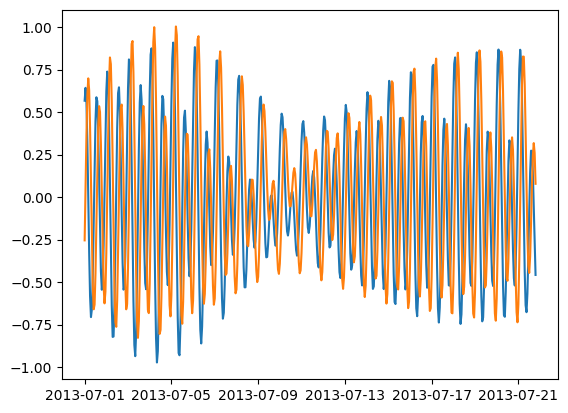

In [213]:
px = 500

# plt.plot(ts.to_datetime()[:px], TIDE.data[:px], label='FES2022')
plt.plot(ts.to_datetime()[:px], soda_pred[:px], label='SODA')
plt.plot(ts.to_datetime()[:px], iwatlas_pred[:px], label='IWATLAS')

In [214]:
iwatlas_nodal = predict_scalar(ts.to_datetime(), [soda_C], Aa_soda, Bb_soda, con_freqs, nodal=True, constituents=constituents_lower)

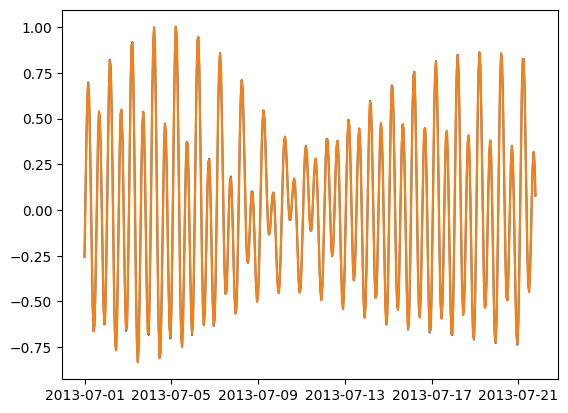

In [215]:
plt.plot(ts.to_datetime()[:px], iwatlas_pred[:px], label='IWATLAS')
plt.plot(ts.to_datetime()[:px], iwatlas_nodal[:px], label='IWATLAS Nodal')

In [218]:
soda_pred_test = harmonic_signal(ts_test.to_datetime(), soda_amp, soda_ph, soda_C, con_freqs, phsbase=datetime(1990,1,1))
iwatlas_pred_test = predict_scalar(ts_test.to_datetime(), [soda_C], Aa_soda, Bb_soda, con_freqs)#, nodal=True, constituents=constituents_lower)
iwatlas_nodal_test = predict_scalar(ts_test.to_datetime(), [soda_C], Aa_soda, Bb_soda, con_freqs, nodal=True, constituents=constituents_lower)

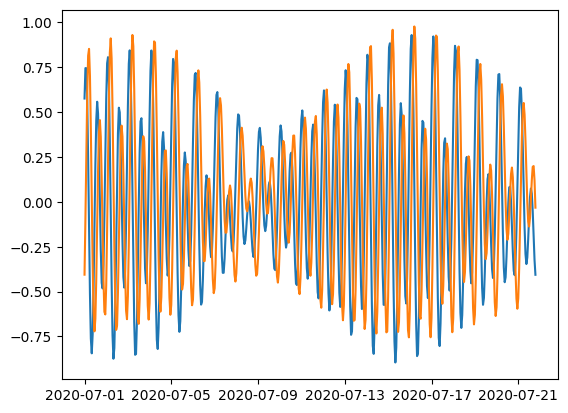

In [219]:
plt.plot(ts_test.to_datetime()[:px], soda_pred_test[:px], label='SODA')
plt.plot(ts_test.to_datetime()[:px], iwatlas_pred_test[:px], label='IWATLAS')

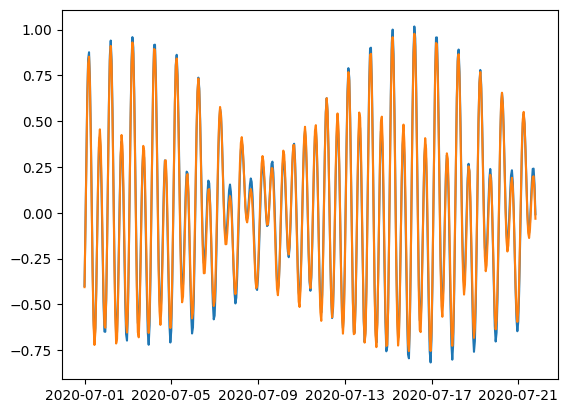

In [223]:
plt.plot(ts_test.to_datetime()[:px], iwatlas_nodal_test[:px], label='IWATLAS Nodal')
plt.plot(ts_test.to_datetime()[:px], iwatlas_pred_test[:px], label='IWATLAS')
